In [1]:
%matplotlib notebook
#Ziyan Zhu
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import socket
import getpass
import nntools as nt
from VOCdataset import VOCDataset

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
print(torch.__version__)

1.1.0


In [4]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012'

In [5]:
labels = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                       'bus',        'car',      'cat',  'chair',     'cow',
                       'diningtable','dog',    'horse',  'motorbike', 'person',
                       'pottedplant','sheep',  'sofa',   'train',   'tvmonitor', 'background']
color = {}
for i in range(len(labels)):    
    color[labels[i]] = np.random.random(3)
    
def myimshow(image, boxes = [], ax = plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = image 
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    if type(boxes['boxes']) == 'torch.Tensor':
        boxes['boxes'] = boxes['boxes'].to('cpu').numpy()
        boxes['labels'] = boxes['labels'].to('cpu').numpy()

    
    for i in range(len(boxes['labels'])):

        ax.gca().add_patch(patches.Rectangle((boxes['boxes'][i][0],boxes['boxes'][i][1]),boxes['boxes'][i][2]- boxes['boxes'][i][0],boxes['boxes'][i][3]-boxes['boxes'][i][1],edgecolor=color[labels[boxes["labels"][i]]],linewidth=1.5,facecolor='none'))
        ax.annotate(labels[boxes["labels"][i]], xy=(boxes['boxes'][i][2], boxes['boxes'][i][1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[boxes["labels"][i]]]))
    ax.axis('off') 
   
    return h

def myimshow_score(image, obj, ax = plt):
    image = image.to('cpu').numpy()
    names = obj['labels'].detach().to('cpu').numpy().astype(int)
    boxes = obj['boxes'].detach().to('cpu').numpy()
    scores = obj['scores'].detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 

    if len(scores) == 0:
        ax.axis('off')
        return h
    elif boxes.shape[0] > 0:
        for i in range(len(names)):
            ax.gca().add_patch(patches.Rectangle((boxes[i][0],boxes[i][1]),boxes[i][2]- boxes[i][0],boxes[i][3]-boxes[i][1],edgecolor=color[labels[names[i]]],linewidth = 1.5, facecolor='none'))
            ax.annotate(labels[names[i]]+ ':' + str(scores[i]), xy=(boxes[i][2], boxes[i][1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[names[i]]]))
        ax.axis('off')
    else:
        ax.gca().add_patch( patches.Rectangle((boxes[0],boxes[1]),boxes[2]- boxes[0],boxes[3]-boxes[1],edgecolor=color[labels[names]],linewidth = 1.5,facecolor='none'))
        ax.annotate(labels[names]+ ':' + str(scores), xy=(boxes[2], boxes[1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[names]]))
        ax.axis('off') 
   
    return h

In [6]:
train_set = VOCDataset(dataset_root_dir)

In [7]:
[x, x_target] = train_set.__getitem__(1105)

In [8]:
x_target

{'boxes': tensor([[108.8000,   2.1333, 753.6000, 736.0000],
         [ 89.6000, 448.0000, 128.0000, 588.8000]]),
 'labels': tensor([ 5, 14], dtype=torch.int32)}

<IPython.core.display.Javascript object>


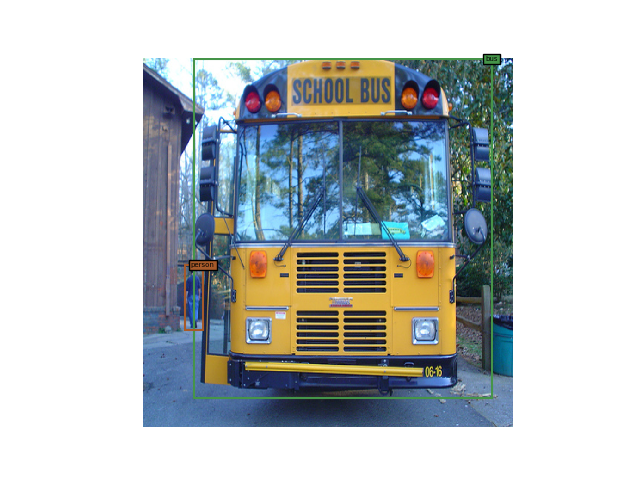

In [9]:
myimshow(x, boxes = x_target)

In [6]:
train_set = VOCDataset(dataset_root_dir)
val_set = VOCDataset(dataset_root_dir,mode="val")

In [8]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
backbone = tv.models.vgg16_bn(pretrained=True).features
# FasterRCNN needs to know the number of output channels in a backbone. For vgg16, it's 512
backbone.out_channels = 512
# let's make the RPN generate 5 x 3 anchors per spatial location, 
# with 5 different sizes and 3 different aspect ratios. 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
# let's define what the feature maps are that we will use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
roi_pooler = tv.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)
# put the pieces together inside a FasterRCNN model
model_vgg16 = FasterRCNN(backbone,num_classes=21,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /tmp/xdg-cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:30<00:00, 18152835.95it/s]


In [9]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init() 
        
    def accumulate(self, loss, x, y, d): 
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d) 
        
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize() 
        return {'loss': loss}

In [10]:
# ignore the pretrained part first
for param in model_vgg16.backbone.parameters():
    param.requires_grad = False

In [12]:
# create experience
lr = 1e-3
model_vgg16 = model_vgg16.to(device)
params = [p for p in model_vgg16.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(model_vgg16, train_set, val_set, optimizer, stats_manager,
                     output_dir="faster_rcnn_vgg16_0", perform_validation_during_training=True)

In [15]:
def plot(exp, fig, axes): 
    axes.clear()
    axes.plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label="traininng loss")
    axes.plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                 label="evaluation loss")
    axes.legend()
    axes.set(xlabel = 'Epoch', ylabel = 'Loss')
    plt.tight_layout()
    fig.canvas.draw()

<IPython.core.display.Javascript object>


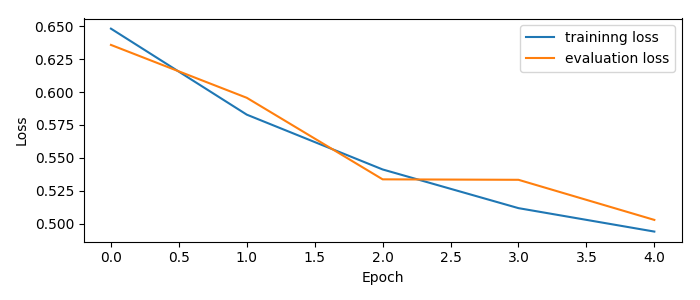

Start/Continue training from epoch 5
Finish training for 5 epochs


In [16]:
# 跑呀跑～加油跑
fig, axes = plt.subplots(ncols=1, figsize=(7, 3))
exp1.run(num_epochs=5, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [13]:
# Now fine tune the pretrained part
new_model = exp1.net
for param in new_model.backbone.parameters():
    param.requires_grad = True

In [14]:
# create experience
lr = 5e-4
new_model = new_model.to(device)
params = [p for p in new_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
stats_manager = ClassificationStatsManager()
exp2 = nt.Experiment(new_model, train_set, val_set, optimizer, stats_manager,
                     output_dir="faster_rcnn_vgg16", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


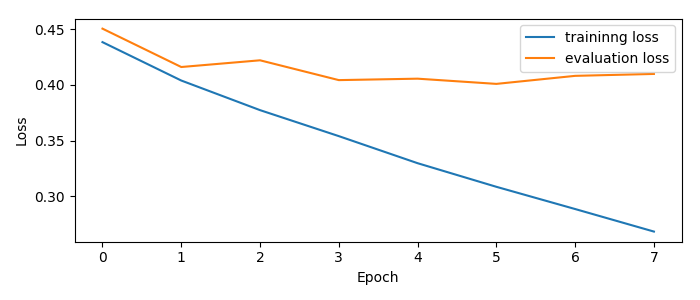

Start/Continue training from epoch 8
Finish training for 8 epochs


In [19]:
# 跑呀跑～加油跑
fig, axes = plt.subplots(ncols=1, figsize=(7, 3))
exp2.run(num_epochs=8, plot=lambda exp: plot(exp, fig=fig, axes=axes))

<IPython.core.display.Javascript object>


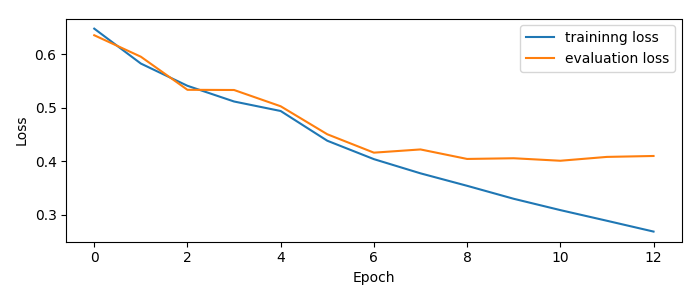

In [20]:
fig, axes = plt.subplots(ncols=1, figsize=(7, 3))
axes.clear()
train = [exp1.history[k][0]['loss'] for k in range(exp1.epoch)] + [exp2.history[k][0]['loss'] for k in range(exp2.epoch)]
val = [exp1.history[k][1]['loss'] for k in range(exp1.epoch)] + [exp2.history[k][1]['loss'] for k in range(exp2.epoch)]
axes.plot(train,
             label="traininng loss")
axes.plot(val,
             label="evaluation loss")

axes.legend()
axes.set(xlabel = 'Epoch', ylabel = 'Loss')
plt.tight_layout()
fig.canvas.draw()


In [33]:
model = exp2.net
model.eval()
with torch.no_grad():
    images, targets = val_set.__getitem__(1215, '2008_002481')
    images = images.to(device)
    #img = images.clone()
    targets['boxes'] = targets['boxes'].to(device)
    targets['labels'] = targets['labels'].to(device)

    prediction = model([images])
    
    print(prediction)
    print("---------------------------------")
    print(targets)
    print("---------------------------------")
    
    res = {'boxes':torch.Tensor([]).to(device),'scores':torch.Tensor([]).to(device),'labels':torch.Tensor([]).to(device).int()}
    objs = set(prediction[0]['labels'].to('cpu').numpy())
    if len(prediction[0]['boxes'].shape) > 1:
        prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'] = exp1.myfilter(prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'], threshold = 0.3)
    
        for k in objs:
            obj_idx = prediction[0]['labels'] == k

            idx = exp1.nms(prediction[0]['boxes'][obj_idx], prediction[0]['scores'][obj_idx], threshold=0.3)

            res['boxes'] = torch.cat((res['boxes'], prediction[0]['boxes'][obj_idx][idx]), 0)
            res['scores'] = torch.cat((res['scores'], prediction[0]['scores'][obj_idx][idx]), 0)
            res['labels'] = torch.cat((res['labels'], prediction[0]['labels'][obj_idx][idx].int()), 0)
    print(res)
    

[{'boxes': tensor([[433.4504, 465.9696, 519.6465, 590.1028],
        [454.9388, 476.3505, 501.6632, 577.8159],
        [425.9248, 508.2987, 520.4967, 568.9826],
        [396.4804, 509.7768, 547.9917, 588.8096],
        [341.2870, 589.2249, 540.4923, 800.0000],
        [387.3272, 486.4795, 496.6093, 595.8745],
        [327.6168, 608.1581, 696.9919, 784.3127],
        [424.3135, 502.2924, 478.7289, 577.5718],
        [344.0196, 589.2750, 426.4277, 800.0000],
        [401.0229, 503.8036, 441.3168, 589.2809],
        [329.3400, 587.0610, 392.0485, 794.6494],
        [351.1861, 463.0532, 519.6390, 625.3238],
        [367.1035, 604.8073, 470.2388, 800.0000],
        [452.6080, 484.5620, 562.2631, 589.3876],
        [412.6775, 450.2205, 588.9523, 610.6875],
        [ 43.9800, 416.0109, 192.3586, 492.4989],
        [573.9550, 650.7268, 660.8387, 777.5210],
        [ 42.9500, 412.8740, 195.1967, 491.1089],
        [362.8840, 629.0941, 405.0880, 771.4869],
        [581.1820, 668.1149, 689.8230, 

<IPython.core.display.Javascript object>


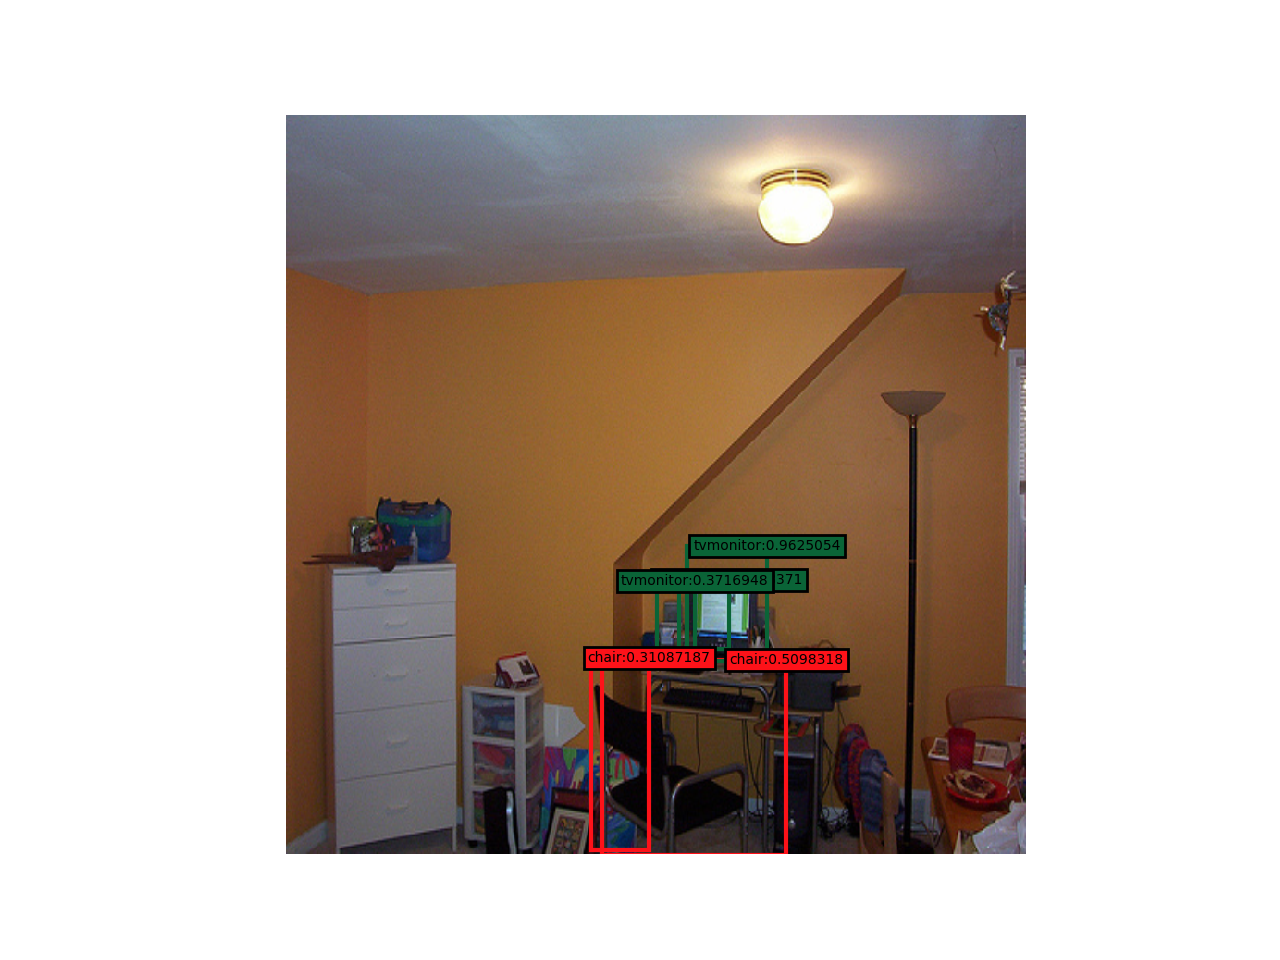

In [34]:
myimshow_score(images, res)

In [36]:
import evaluation_voc
model = exp2.net
model.eval()
recall, precision, aps = evaluation_voc.run(model,val_set,device,thr = 0.5)

In [ ]:
import os
base_dir = os.getcwd()
file_name = os.path.join(base_dir, 'evaluation.txt')
my_open = open(file_name, 'a')
my_open.write('VGG\n')
my_open.write(str(aps))
my_open.write('\n')
my_open.close()

In [37]:
aps

{19: 0.36215837880677326,
 2: 0.3695608641128983,
 7: 0.5725898237900585,
 8: 0.21677696247564995,
 17: 0.18982920464094633,
 18: 0.3772062875800415,
 14: 0.48081606132205257,
 11: 0.5317027991673113,
 5: 0.49172576682458596,
 3: 0.13969517425738623,
 4: 0.18887891021422565,
 15: 0.15799184567602761,
 9: 0.17864814788684813,
 16: 0.36745845908546837,
 0: 0.0,
 6: 0.3970463884457763,
 10: 0.1537023853878362,
 12: 0.3958032705260312,
 13: 0.4665655720808621,
 1: 0.4224848633732009}

<IPython.core.display.Javascript object>


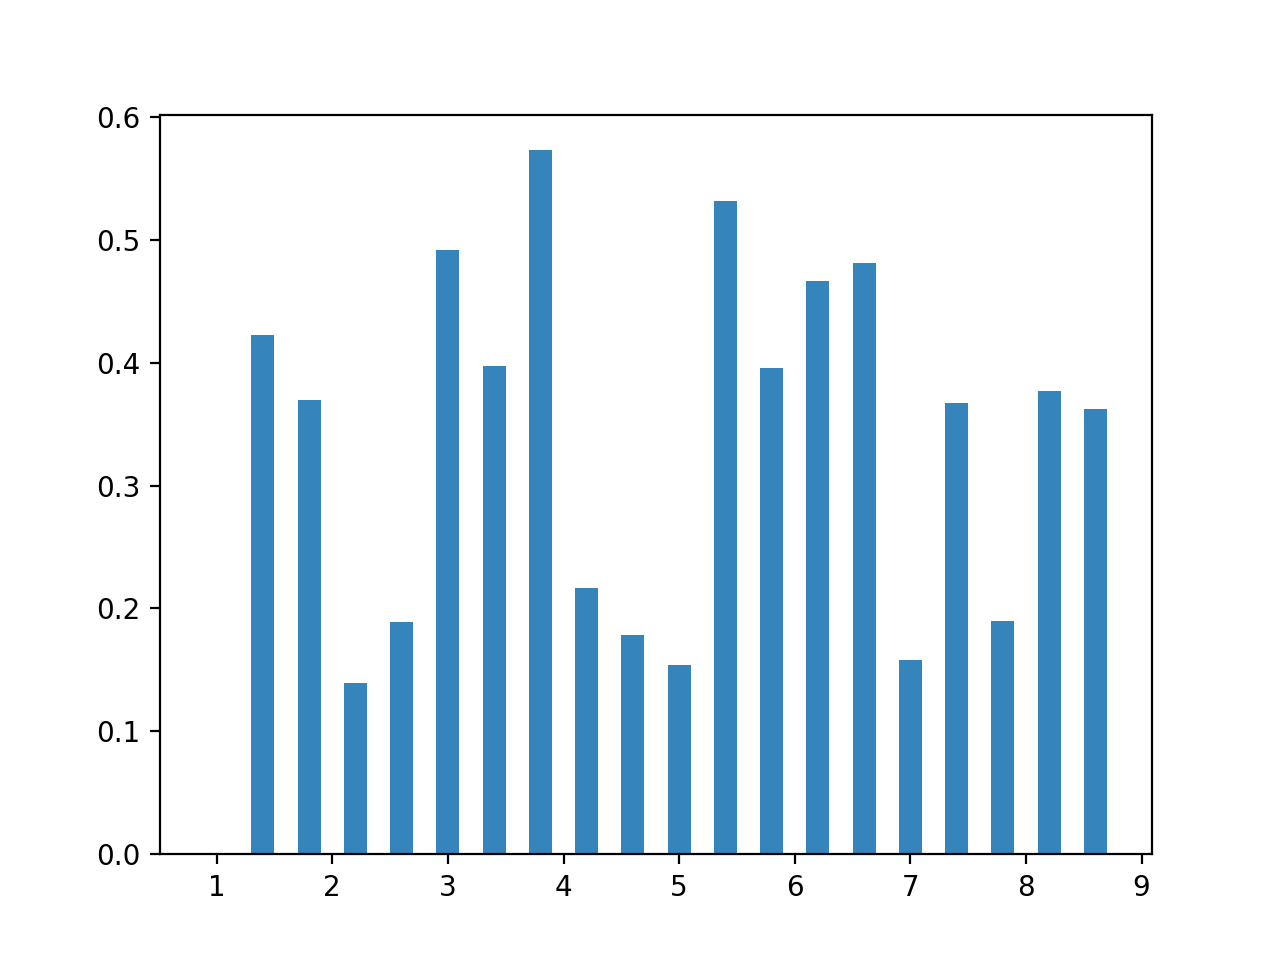

In [40]:
x = np.arange(20)   
y = [mAP[i] for i in x]   
#y1 = [5,6]  
width = 0.5   
fig,ax = plt.subplots()
ax.bar(x,y,width,alpha = 0.9)
#ax.bar(x+width,y1,width,alpha = 0.9,color= 'red')
#ax.set_xticks(x +width/2)
ax.set_xticklabels(x)
plt.show()